# Logistic Regression from Scratch

This notebook implements logistic regression using gradient descent with both vectorized and non-vectorized approaches on the UCI Adult Dataset. We'll compare performance and analyze the results.

## Tasks to Complete:
- Implement both vectorized and non-vectorized logistic regression
- Plot training loss vs. epochs
- Plot accuracy on training and validation sets vs. epochs  
- Evaluate final model: accuracy, precision, recall, F1-score on test set
- Create confusion matrix
- Compare performance between vectorized vs. non-vectorized implementations


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from urllib.request import urlretrieve
import os
import time
from types import SimpleNamespace

# Configuration parameters
cfg = SimpleNamespace(**{})

# General
cfg.seed = 42

# Data splits
cfg.train_split = 0.7
cfg.val_split = 0.15
# test_split = 1.0 - 0.7 - 0.15 = 0.15

# Logistic regression parameters
cfg.lr_logistic_non_vectorized = 0.05
cfg.lr_logistic_vectorized = 0.005
cfg.epochs_logistic_non_vectorized = 90
cfg.epochs_logistic_vectorized = 1500
cfg.results_dir_logistic = "results_logistic"

print("Configuration loaded successfully!")

Configuration loaded successfully!


## Data Loading and Preprocessing Functions

First, let's define functions to download and preprocess the UCI Adult Dataset.


In [27]:
def download_and_load_adult_dataset():
    """Downloads UCI Adult Dataset and returns separate train and test DataFrames."""
    data_url = (
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    )
    test_url = (
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
    )

    data_path = "data/adult_data.csv"
    test_path = "data/adult_test.csv"

    # Ensure data directory exists
    os.makedirs(os.path.dirname(data_path), exist_ok=True)

    if not os.path.exists(data_path):
        print("Downloading adult.data ...")
        urlretrieve(data_url, data_path)
    if not os.path.exists(test_path):
        print("Downloading adult.test ...")
        urlretrieve(test_url, test_path)

    columns = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ]

    try:
        # Training data has no header row and no comment lines at the beginning
        df_train = pd.read_csv(
            data_path, names=columns, na_values="?", skipinitialspace=True
        )
        # Test data has an initial comment line and the target label has a dot at the end
        df_test = pd.read_csv(
            test_path, names=columns, na_values="?", skipinitialspace=True, skiprows=1
        )
    except Exception as e:
        print(f"Error reading CSV files: {e}")
        return None, None

    # Correct target label in test set (e.g. ">50K." -> ">50K")
    df_test["income"] = df_test["income"].str.replace(".", "", regex=False)

    return df_train, df_test


In [28]:
def preprocess_adult_data(df_train, df_test):
    """Prepares the Adult DataFrames for logistic regression."""
    print("Starting data processing...")

    # Make copies to avoid modifying original data
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()

    # Handle missing values using training data statistics only
    for col in df_train_copy.columns:
        if df_train_copy[col].dtype == "object":
            # Use mode from training data for both train and test
            mode_value = (
                df_train_copy[col].mode()[0]
                if not df_train_copy[col].mode().empty
                else "Unknown"
            )
            df_train_copy[col] = df_train_copy[col].fillna(mode_value)
            df_test_copy[col] = df_test_copy[col].fillna(mode_value)
        else:
            # Use median from training data for both train and test
            median_value = df_train_copy[col].median()
            df_train_copy[col] = df_train_copy[col].fillna(median_value)
            df_test_copy[col] = df_test_copy[col].fillna(median_value)

    # Convert categorical variables to numerical (One-Hot Encoding)
    # Fit encoding on training data only, then apply to both
    categorical_cols = df_train_copy.select_dtypes(include=["object"]).columns.tolist()

    # Handle target variable income separately
    if "income" in categorical_cols:
        categorical_cols.remove("income")

    # Combine train and test temporarily ONLY for consistent one-hot encoding
    # This ensures both datasets have the same columns
    df_combined = pd.concat([df_train_copy, df_test_copy], keys=["train", "test"])
    df_encoded = pd.get_dummies(df_combined, columns=categorical_cols, drop_first=True)

    # Split back into train and test
    df_train_encoded = df_encoded.loc["train"].reset_index(drop=True)
    df_test_encoded = df_encoded.loc["test"].reset_index(drop=True)

    # Convert target variable: >50K -> 1, <=50K -> 0
    df_train_encoded["income"] = df_train_encoded["income"].apply(
        lambda x: 1 if x.strip() == ">50K" else 0
    )
    df_test_encoded["income"] = df_test_encoded["income"].apply(
        lambda x: 1 if x.strip() == ">50K" else 0
    )

    # Separate features and targets
    y_train_full = df_train_encoded["income"].values
    y_test = df_test_encoded["income"].values

    X_train_df = df_train_encoded.drop("income", axis=1)
    X_test_df = df_test_encoded.drop("income", axis=1)

    # Ensure all columns are numeric
    for col in X_train_df.columns:
        X_train_df[col] = pd.to_numeric(X_train_df[col], errors="coerce")
        X_test_df[col] = pd.to_numeric(X_test_df[col], errors="coerce")

    # Fill any NaN values that might have been created during conversion
    X_train_df = X_train_df.fillna(0)
    X_test_df = X_test_df.fillna(0)

    X_train_full = X_train_df.values.astype(np.float64)
    X_test = X_test_df.values.astype(np.float64)

    print(
        f"Shape of X_train after One-Hot-Encoding (before normalization): {X_train_full.shape}"
    )
    print(
        f"Shape of X_test after One-Hot-Encoding (before normalization): {X_test.shape}"
    )

    # Split training data into train and validation
    num_train_samples = X_train_full.shape[0]
    np.random.seed(cfg.seed)  # For reproducibility
    train_indices = np.random.permutation(num_train_samples)

    train_end_idx = int(
        cfg.train_split / (cfg.train_split + cfg.val_split) * num_train_samples
    )

    train_idx = train_indices[:train_end_idx]
    val_idx = train_indices[train_end_idx:]

    X_train, y_train = X_train_full[train_idx], y_train_full[train_idx]
    X_val, y_val = X_train_full[val_idx], y_train_full[val_idx]

    # Normalize features using only training data statistics
    mean_X_train = np.mean(X_train, axis=0)
    std_X_train = np.std(X_train, axis=0)
    std_X_train[std_X_train == 0] = 1  # Avoid division by zero for constant columns

    # Apply normalization to all sets using training statistics
    X_train_normalized = (X_train - mean_X_train) / std_X_train
    X_val_normalized = (X_val - mean_X_train) / std_X_train
    X_test_normalized = (X_test - mean_X_train) / std_X_train

    # Add bias term x0 = 1
    X_train_final = np.concatenate(
        [np.ones((X_train_normalized.shape[0], 1)), X_train_normalized], axis=1
    )
    X_val_final = np.concatenate(
        [np.ones((X_val_normalized.shape[0], 1)), X_val_normalized], axis=1
    )
    X_test_final = np.concatenate(
        [np.ones((X_test_normalized.shape[0], 1)), X_test_normalized], axis=1
    )

    print("Data preprocessing completed.")
    print(f"Shapes: X_train: {X_train_final.shape}, y_train: {y_train.shape}")
    print(f"Shapes: X_val: {X_val_final.shape}, y_val: {y_val.shape}")
    print(f"Shapes: X_test: {X_test_final.shape}, y_test: {y_test.shape}")

    return X_train_final, y_train, X_val_final, y_val, X_test_final, y_test

## Core Logistic Regression Functions

In [29]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))


def binary_cross_entropy_loss(y_true, y_pred_proba):
    """Calculates the binary cross-entropy loss."""
    epsilon = 1e-15  # To avoid log(0)
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    m = len(y_true)
    cost = (-1 / m) * np.sum(
        y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba)
    )
    return cost


def calculate_accuracy(y_true, y_pred_proba):
    """Calculates classification accuracy."""
    y_pred_class = (y_pred_proba >= 0.5).astype(int)
    accuracy = np.mean(y_pred_class == y_true)
    return accuracy

## Non-Vectorized Implementation

This implementation uses nested loops to calculate gradients manually for each training example and each feature.


In [30]:
def logistic_regression_gd_non_vectorized(X_train, y_train, X_val, y_val):
    """Logistic regression with non-vectorized gradient descent."""
    m, n = X_train.shape
    theta = np.zeros(n)

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(
        f"Starting non-vectorized training: LR={cfg.lr_logistic_non_vectorized}, Epochs={cfg.epochs_logistic_non_vectorized}"
    )

    progress_bar = tqdm.trange(
        cfg.epochs_logistic_non_vectorized,
        desc="Training",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]",
    )

    for epoch in progress_bar:
        gradients = np.zeros(n)
        # Predictions for training data in this epoch (for loss and accuracy)
        h_theta_train_epoch = np.zeros(m)

        for i in range(m):  # Loop over each training example
            xi = X_train[i, :]
            yi = y_train[i]

            zi = np.dot(xi, theta)
            h_theta_xi = sigmoid(zi)
            h_theta_train_epoch[i] = h_theta_xi  # Store prediction

            error_i = h_theta_xi - yi

            for j in range(n):  # Loop over each feature
                gradients[j] += error_i * xi[j]

        gradients /= m  # Average of gradients
        theta -= cfg.lr_logistic_non_vectorized * gradients

        # Loss and accuracy for training data
        current_train_loss = binary_cross_entropy_loss(y_train, h_theta_train_epoch)
        current_train_acc = calculate_accuracy(y_train, h_theta_train_epoch)
        train_loss_history.append(current_train_loss)
        train_acc_history.append(current_train_acc)

        # Loss and accuracy for validation data
        val_pred_proba = sigmoid(np.dot(X_val, theta))
        current_val_loss = binary_cross_entropy_loss(y_val, val_pred_proba)
        current_val_acc = calculate_accuracy(y_val, val_pred_proba)
        val_loss_history.append(current_val_loss)
        val_acc_history.append(current_val_acc)

        progress_bar.set_postfix(
            Train_Loss=current_train_loss, Val_Loss=current_val_loss
        )

    return (
        theta,
        train_loss_history,
        val_loss_history,
        train_acc_history,
        val_acc_history,
    )

## Vectorized Implementation

This implementation uses matrix operations to calculate gradients efficiently for all training examples at once.


In [31]:
def logistic_regression_gd_vectorized(X_train, y_train, X_val, y_val):
    """Logistic regression with vectorized gradient descent."""
    m, n = X_train.shape
    theta = np.zeros(n)

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(
        f"Starting vectorized training: LR={cfg.lr_logistic_vectorized}, Epochs={cfg.epochs_logistic_vectorized}"
    )

    progress_bar = tqdm.trange(
        cfg.epochs_logistic_vectorized,
        desc="Training",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]",
    )

    for epoch in progress_bar:
        z_train = np.dot(X_train, theta)
        h_theta_train = sigmoid(z_train)  # Vectorized prediction

        errors = h_theta_train - y_train
        gradients = (1 / m) * np.dot(X_train.T, errors)  # Vectorized gradient

        theta -= cfg.lr_logistic_vectorized * gradients

        # Loss and accuracy for training data
        current_train_loss = binary_cross_entropy_loss(y_train, h_theta_train)
        current_train_acc = calculate_accuracy(y_train, h_theta_train)
        train_loss_history.append(current_train_loss)
        train_acc_history.append(current_train_acc)

        # Loss and accuracy for validation data
        val_pred_proba = sigmoid(np.dot(X_val, theta))
        current_val_loss = binary_cross_entropy_loss(y_val, val_pred_proba)
        current_val_acc = calculate_accuracy(y_val, val_pred_proba)
        val_loss_history.append(current_val_loss)
        val_acc_history.append(current_val_acc)

        progress_bar.set_postfix(
            Train_Loss=current_train_loss, Val_Loss=current_val_loss
        )

    return (
        theta,
        train_loss_history,
        val_loss_history,
        train_acc_history,
        val_acc_history,
    )

## Plotting and Evaluation Functions

Functions to create learning curves, confusion matrices, and evaluate the final model performance.


In [32]:
def plot_learning_curves(train_hist, val_hist, title, ylabel, filename_suffix):
    plt.figure(figsize=(10, 6))
    plt.plot(train_hist, label=f"Training {ylabel}")
    plt.plot(val_hist, label=f"Validation {ylabel}")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    filepath = os.path.join(cfg.results_dir_logistic, f"{filename_suffix}.png")
    plt.savefig(filepath)
    print(f"Plot saved: {filepath}")
    plt.show()


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred <=50K", "Pred >50K"])
    plt.yticks(tick_marks, ["Actual <=50K", "Actual >50K"])

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    filepath = os.path.join(cfg.results_dir_logistic, "confusion_matrix_test.png")
    plt.savefig(filepath)
    print(f"Confusion Matrix saved: {filepath}")
    plt.show()


def evaluate_model_on_test_set(theta, X_test, y_test):
    """Evaluates the model on the test set and outputs metrics."""
    y_pred_proba_test = sigmoid(np.dot(X_test, theta))
    y_pred_class_test = (y_pred_proba_test >= 0.5).astype(int)

    # Calculate metrics
    tp = np.sum((y_test == 1) & (y_pred_class_test == 1))
    tn = np.sum((y_test == 0) & (y_pred_class_test == 0))
    fp = np.sum((y_test == 0) & (y_pred_class_test == 1))
    fn = np.sum((y_test == 1) & (y_pred_class_test == 0))

    accuracy = (tp + tn) / len(y_test) if len(y_test) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test Precision: {precision:.4f}")
    print(f"  Test Recall: {recall:.4f}")
    print(f"  Test F1-Score: {f1_score:.4f}")

    # Plot Confusion Matrix
    cm = np.array([[tn, fp], [fn, tp]])
    plot_confusion_matrix(cm, "Confusion Matrix (Test Set)")

    return accuracy, precision, recall, f1_score

## Data Loading and Preprocessing

In [33]:
print("Starting Logistic Regression Assignment...")

# Ensure results directory exists
os.makedirs(cfg.results_dir_logistic, exist_ok=True)

# Load and prepare data
df_train, df_test = download_and_load_adult_dataset()

X_train, y_train, X_val, y_val, X_test, y_test = preprocess_adult_data(
    df_train, df_test
)


Starting Logistic Regression Assignment...


Starting data processing...
Shape of X_train after One-Hot-Encoding (before normalization): (32561, 97)
Shape of X_test after One-Hot-Encoding (before normalization): (16281, 97)
Data preprocessing completed.
Shapes: X_train: (26814, 98), y_train: (26814,)
Shapes: X_val: (5747, 98), y_val: (5747,)
Shapes: X_test: (16281, 98), y_test: (16281,)


## Training Non-Vectorized Implementation

Training the logistic regression model using the non-vectorized approach with nested loops.


In [34]:
print("\n--- Training Non-Vectorized Logistic Regression ---")
start_time_non_vec = time.time()
theta_nv, train_loss_nv, val_loss_nv, train_acc_nv, val_acc_nv = (
    logistic_regression_gd_non_vectorized(X_train, y_train, X_val, y_val)
)
end_time_non_vec = time.time()
print(
    f"Training time (Non-Vectorized): {end_time_non_vec - start_time_non_vec:.2f} seconds"
)

# Store the training time for comparison
non_vec_time = end_time_non_vec - start_time_non_vec



--- Training Non-Vectorized Logistic Regression ---
Starting non-vectorized training: LR=0.05, Epochs=90


Training: 100%|██████████| 90/90 [03:19<00:00,  2.22s/it, Train_Loss=0.408, Val_Loss=0.408]

Training time (Non-Vectorized): 199.68 seconds


### Plot Learning Curves for Non-Vectorized Implementation


Plot saved: results_logistic/loss_non_vectorized_logistic.png


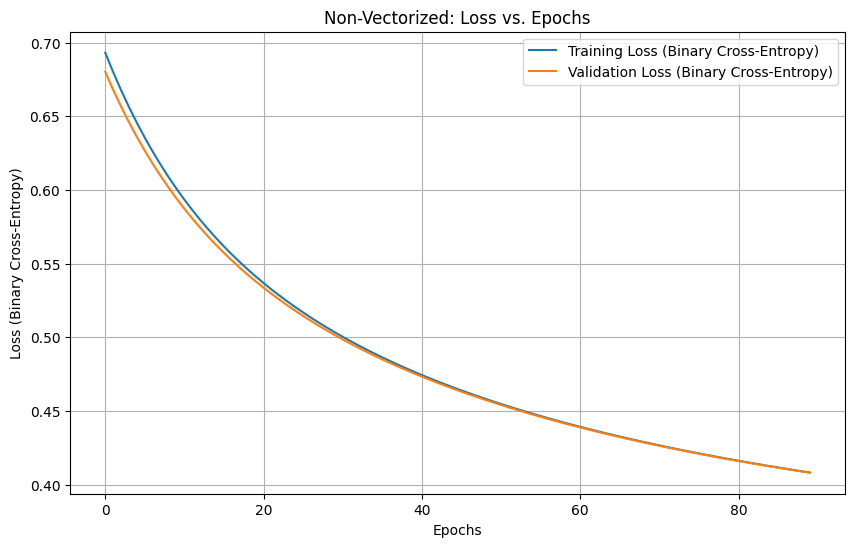

Plot saved: results_logistic/accuracy_non_vectorized_logistic.png


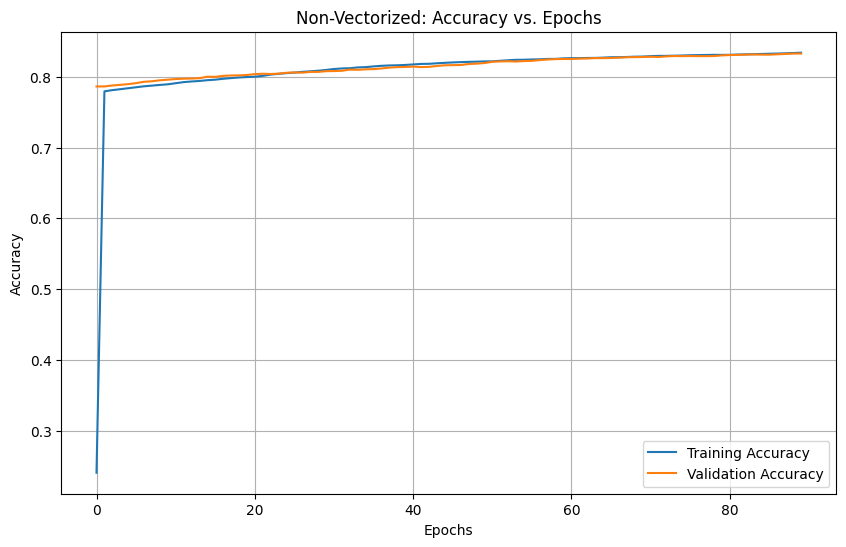

In [35]:
# Plot loss curves for non-vectorized implementation
plot_learning_curves(
    train_loss_nv,
    val_loss_nv,
    "Non-Vectorized: Loss vs. Epochs",
    "Loss (Binary Cross-Entropy)",
    "loss_non_vectorized_logistic",
)

# Plot accuracy curves for non-vectorized implementation
plot_learning_curves(
    train_acc_nv,
    val_acc_nv,
    "Non-Vectorized: Accuracy vs. Epochs",
    "Accuracy",
    "accuracy_non_vectorized_logistic",
)


### Evaluate Non-Vectorized Model on Test Set



Evaluation of non-vectorized model on test set:
  Test Accuracy: 0.8339
  Test Precision: 0.6446
  Test Recall: 0.6617
  Test F1-Score: 0.6531
Confusion Matrix saved: results_logistic/confusion_matrix_test.png


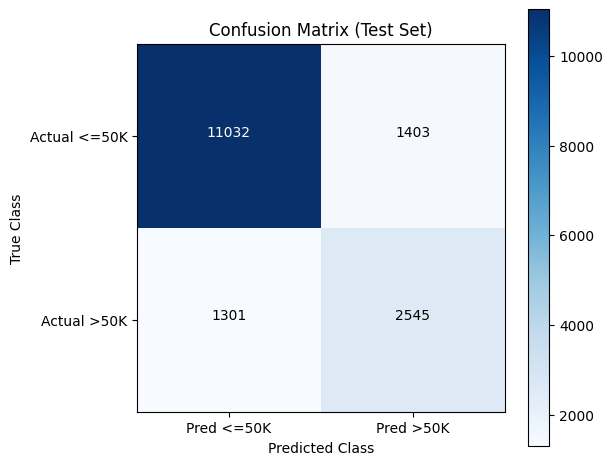

In [36]:
print("\nEvaluation of non-vectorized model on test set:")
nv_accuracy, nv_precision, nv_recall, nv_f1 = evaluate_model_on_test_set(
    theta_nv, X_test, y_test
)


## Training Vectorized Implementation

Training the logistic regression model using the vectorized approach with matrix operations.


In [37]:
print("\n--- Training Vectorized Logistic Regression ---")
start_time_vec = time.time()
theta_v, train_loss_v, val_loss_v, train_acc_v, val_acc_v = (
    logistic_regression_gd_vectorized(X_train, y_train, X_val, y_val)
)
end_time_vec = time.time()
print(f"Training time (Vectorized): {end_time_vec - start_time_vec:.2f} seconds")

# Store the training time for comparison
vec_time = end_time_vec - start_time_vec



--- Training Vectorized Logistic Regression ---
Starting vectorized training: LR=0.005, Epochs=1500


Training: 100%|██████████| 1500/1500 [00:32<00:00, 46.23it/s, Train_Loss=0.375, Val_Loss=0.375]

Training time (Vectorized): 32.45 seconds


### Plot Learning Curves for Vectorized Implementation


Plot saved: results_logistic/loss_vectorized_logistic.png


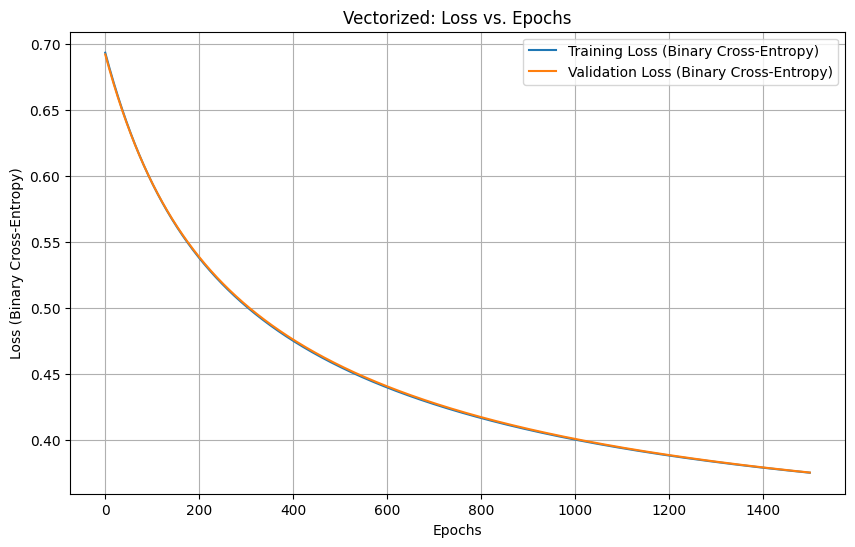

Plot saved: results_logistic/accuracy_vectorized_logistic.png


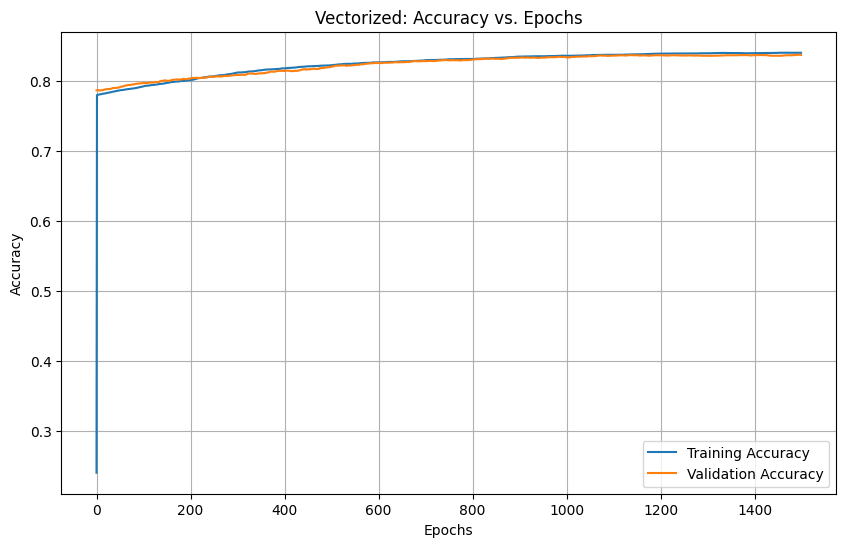

In [38]:
# Plot loss curves for vectorized implementation
plot_learning_curves(
    train_loss_v,
    val_loss_v,
    "Vectorized: Loss vs. Epochs",
    "Loss (Binary Cross-Entropy)",
    "loss_vectorized_logistic",
)

# Plot accuracy curves for vectorized implementation
plot_learning_curves(
    train_acc_v,
    val_acc_v,
    "Vectorized: Accuracy vs. Epochs",
    "Accuracy",
    "accuracy_vectorized_logistic",
)


### Evaluate Vectorized Model on Test Set



Evaluation of vectorized model on test set:
  Test Accuracy: 0.8401
  Test Precision: 0.6773
  Test Recall: 0.6173
  Test F1-Score: 0.6459
Confusion Matrix saved: results_logistic/confusion_matrix_test.png


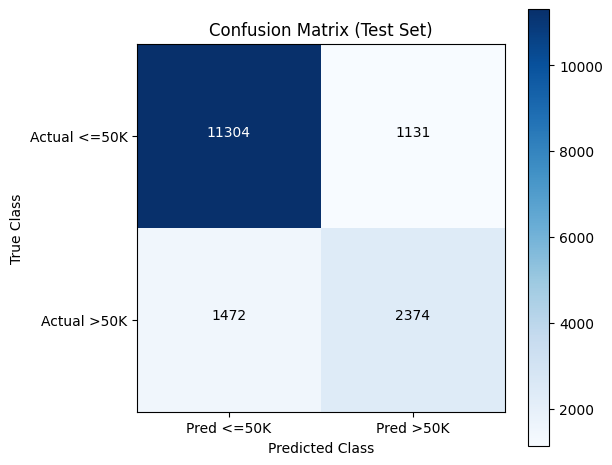

In [39]:
print("\nEvaluation of vectorized model on test set:")
v_accuracy, v_precision, v_recall, v_f1 = evaluate_model_on_test_set(
    theta_v, X_test, y_test
)

## Performance Comparison and Analysis

Comparing the performance between vectorized and non-vectorized implementations.



=== PERFORMANCE COMPARISON ===
Non-vectorized training time: 199.68 seconds
Vectorized training time: 32.45 seconds
Speedup (Non-vec / Vec): 6.15x

=== MODEL PERFORMANCE COMPARISON ===
Non-Vectorized Model:
  Accuracy: 0.8339
  Precision: 0.6446
  Recall: 0.6617
  F1-Score: 0.6531

Vectorized Model:
  Accuracy: 0.8401
  Precision: 0.6773
  Recall: 0.6173
  F1-Score: 0.6459

Comparison plot saved: results_logistic/performance_comparison.png


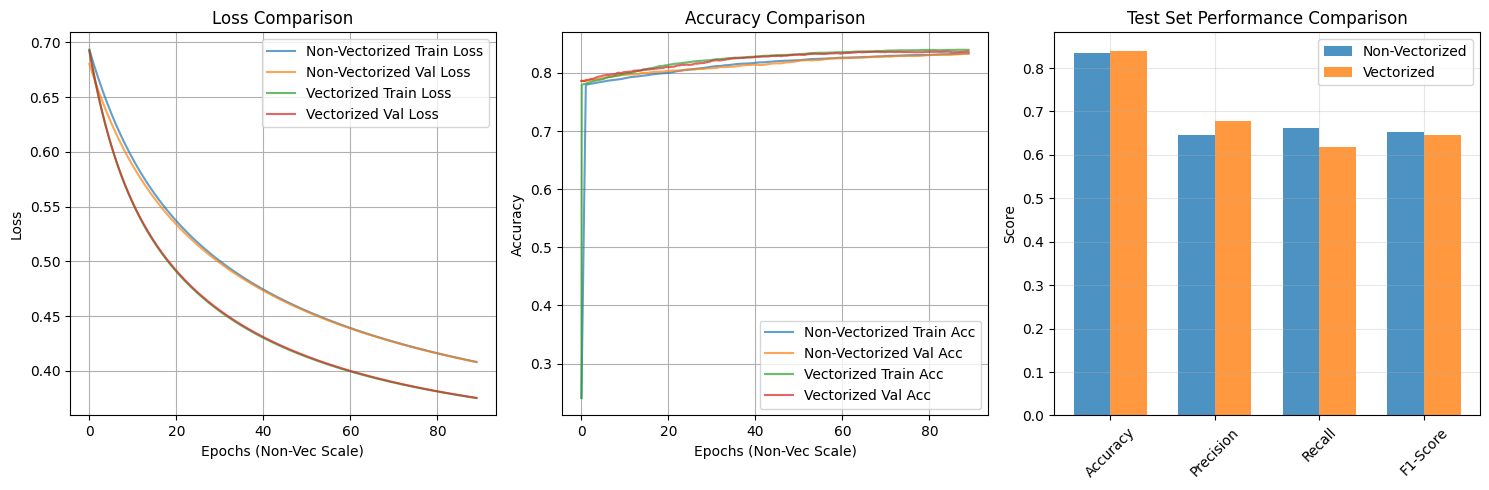

In [40]:
print("\n=== PERFORMANCE COMPARISON ===")
print(f"Non-vectorized training time: {non_vec_time:.2f} seconds")
print(f"Vectorized training time: {vec_time:.2f} seconds")
speedup = non_vec_time / vec_time
print(f"Speedup (Non-vec / Vec): {speedup:.2f}x")

print("\n=== MODEL PERFORMANCE COMPARISON ===")
print("Non-Vectorized Model:")
print(f"  Accuracy: {nv_accuracy:.4f}")
print(f"  Precision: {nv_precision:.4f}")
print(f"  Recall: {nv_recall:.4f}")
print(f"  F1-Score: {nv_f1:.4f}")

print("\nVectorized Model:")
print(f"  Accuracy: {v_accuracy:.4f}")
print(f"  Precision: {v_precision:.4f}")
print(f"  Recall: {v_recall:.4f}")
print(f"  F1-Score: {v_f1:.4f}")

# Side-by-side comparison plot of training curves
plt.figure(figsize=(15, 5))

# Loss comparison
plt.subplot(1, 3, 1)
plt.plot(train_loss_nv, label="Non-Vectorized Train Loss", alpha=0.7)
plt.plot(val_loss_nv, label="Non-Vectorized Val Loss", alpha=0.7)
# For vectorized, we need to adjust the x-axis since it has more epochs
epochs_vec = np.linspace(0, len(train_loss_nv) - 1, len(train_loss_v))
plt.plot(epochs_vec, train_loss_v, label="Vectorized Train Loss", alpha=0.7)
plt.plot(epochs_vec, val_loss_v, label="Vectorized Val Loss", alpha=0.7)
plt.title("Loss Comparison")
plt.xlabel("Epochs (Non-Vec Scale)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy comparison
plt.subplot(1, 3, 2)
plt.plot(train_acc_nv, label="Non-Vectorized Train Acc", alpha=0.7)
plt.plot(val_acc_nv, label="Non-Vectorized Val Acc", alpha=0.7)
plt.plot(epochs_vec, train_acc_v, label="Vectorized Train Acc", alpha=0.7)
plt.plot(epochs_vec, val_acc_v, label="Vectorized Val Acc", alpha=0.7)
plt.title("Accuracy Comparison")
plt.xlabel("Epochs (Non-Vec Scale)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Performance metrics comparison
plt.subplot(1, 3, 3)
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
non_vec_scores = [nv_accuracy, nv_precision, nv_recall, nv_f1]
vec_scores = [v_accuracy, v_precision, v_recall, v_f1]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, non_vec_scores, width, label="Non-Vectorized", alpha=0.8)
plt.bar(x + width / 2, vec_scores, width, label="Vectorized", alpha=0.8)

plt.title("Test Set Performance Comparison")
plt.ylabel("Score")
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
comparison_filepath = os.path.join(
    cfg.results_dir_logistic, "performance_comparison.png"
)
plt.savefig(comparison_filepath)
print(f"\nComparison plot saved: {comparison_filepath}")
plt.show()


## Summary and Analysis

Both model versions delivered similar classification performance. 
However, the vectorized implementation was dramatically faster, completing training in just 32.45 seconds compared to the non-vectorized version's 199.68 seconds – a 6.15x speedup.

This efficiency comes from NumPy's optimized matrix operations, which avoid slow Python loops and leverage parallel processing.
 While the non-vectorized model used fewer epochs, the vectorized approach's rapid per-epoch speed made it substantially more efficient overall.

